In [43]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

In [2]:
from nltk.metrics import masi_distance
from collections import Counter
from nltk.metrics import agreement
from nltk.metrics.agreement import AnnotationTask

In [3]:
import re

def depersonalize(text):
    text = str(text)
    url_regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    text= re.sub(url_regex, "url", text)
    text = re.sub("id[\d]*",'',text)
    text = re.sub("> ?",'',text)
    text = re.sub("@[\w]*",'',text)
#     text = re.sub("\+[\d]*", "", text)
    text = re.sub("[\d]+", "NUMBER", text)
    text = re.sub(">>", "", text)
#     text = re.sub("[\d]{3,100}", "", text)
    text = re.sub("[\t|\n|\r]", "", text)
    text = re.sub("[(OP)|url|nickname|phone_number]", "", text)
    return text

In [4]:
df_sensitive = pd.read_csv("sensitive_topics_vs_source.csv")

In [5]:
Counter(df_sensitive['source'])

Counter({'toloka': 9291, 'trtest': 378, 'self': 1978, 'kw': 21656})

In [10]:
df_sensitive_toloka = df_sensitive[df_sensitive['source'] == 'toloka']
toloka_trtes_set = set(df_sensitive[df_sensitive['source']=='trtest']['text'])

In [11]:
len(toloka_trtes_set)

378

In [8]:
df_sensitive_toloka_texts_set = set(df_sensitive_toloka['text'])
len(df_sensitive_toloka_texts_set)

9291

In [9]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [12]:
def calc_agreement_nltk(df_group):
    worker2id = {}
    for pair in df_group['ASSIGNMENT:worker_id'].tolist():
        if pair not in worker2id:
            worker2id[pair] = len(worker2id)
    df_group['worker_idx'] = df_group['ASSIGNMENT:worker_id'].map(worker2id)
    
    text2ids = {}
    for t in set(df_group['INPUT:text'].tolist()):
        if t not in text2ids:
            text2ids[t] = len(text2ids)
    df_group['text_idx'] = df_group['INPUT:text'].map(text2ids)
    ids2text = {idx:text for text,idx in text2ids.items()}
    
    reply_columns = [c for c in df_group.columns if 'OUTPUT' in c]
    
    collected_data = []
    item_idx_dict = {}
    
    for i,el in df_group.iterrows():
        coder_idx = el['worker_idx']
        
        item_idx = el['text_idx']
        
        if item_idx in item_idx_dict:
            item_idx_dict[item_idx] += 1
        else:
            item_idx_dict[item_idx] = 1
            
        labels_list = []
        for repl in reply_columns:
            if el[repl] == True:
                labels_list.append(repl[7:])

        if len(labels_list) == 0: labels_list = ['none']
        collected_triplet = (coder_idx,item_idx,frozenset(labels_list))
        collected_data.append(collected_triplet)
        
    task = AnnotationTask(distance = masi_distance)
    
    task.load_array(collected_data)
    
    return task.alpha()

def get_high_conf_texts(df_hc, thrsh):
    confidnece_columns = []
    for c in df_hc.columns:
        if 'CONFIDENCE' in c:
            df_hc[c] = df_hc[c].apply(lambda x: float(x[:-1])/100)
            confidnece_columns.append(c)
            
    df_hc['meet_req'] = df_hc.apply(lambda x: all([x[c] > thrsh for c in confidnece_columns]), axis = 1)
    
    return set(df_hc[df_hc['meet_req'] == True]['INPUT:text'])
    
def get_aggr_batch_with_filtering(batch_name, drop_unconfident_thrsh = None, 
                                  drop_traintest_examples = False, print_output = False, drop_trtest = True):
    if batch_name == 'first': 
        raw_files = ['g1r.tsv','g2r.tsv','g3r.tsv']
    elif batch_name == 'fourth':
        raw_files = ['g1_4r.tsv','g2_4r.tsv','g3_4r.tsv']
    elif batch_name == 'old':
        raw_files = ['maybe_old/g1r.tsv','maybe_old/g2r.tsv']
    
    engaged_texts= set()
   
    collected_agreements = []

    for i, file in enumerate(raw_files):
        if print_output == True: print("="*100)
        batch_path = "./directly_from_toloka/"+file
        df_curr_common= pd.read_csv(batch_path, sep = '\t')
        
        if drop_trtest == True:
            if print_output == True: print("before dropping trtest ...", len(df_curr_common))
            df_curr_common = df_curr_common[~df_curr_common['INPUT:text'].isin(toloka_trtes_set)]#!!
            if print_output == True: print("after dropping trtest ...", len(df_curr_common))
            
        if drop_unconfident_thrsh:
            file_agg = re.sub('r','',file)
            batch_path_agg = "./directly_from_toloka/"+file_agg
            df_curr_agg = pd.read_csv(batch_path_agg, sep = '\t')
        
            current_high_conf_texts = get_high_conf_texts(df_curr_agg, drop_unconfident_thrsh)
            
            if print_output == True: print("before dropping low conf ... ", len(df_curr_common))
            df_curr_common = df_curr_common[df_curr_common['INPUT:text'].isin(current_high_conf_texts)]
            if print_output == True: print("after dropping low conf ...", len(df_curr_common))
                
        engaged_texts = engaged_texts.union(set(df_curr_common['INPUT:text']))
        
        columns_to_merge = [c for c in df_curr_common.columns if c == 'INPUT:text' or 'OUTPUT' in c  or c =='ASSIGNMENT:worker_id']
        df_curr_common = df_curr_common[columns_to_merge]
        
        alpha_curr = calc_agreement_nltk(df_curr_common)
            
        collected_agreements.append(alpha_curr)
            
    return collected_agreements, engaged_texts

aggr, eng_txts = get_aggr_batch_with_filtering('first',drop_unconfident_thrsh = 0.8, print_output = True)

before dropping trtest ... 12705
after dropping trtest ... 10006
before dropping low conf ...  10006
after dropping low conf ... 7668
before dropping trtest ... 15009
after dropping trtest ... 12250
before dropping low conf ...  12250
after dropping low conf ... 8540
before dropping trtest ... 16934
after dropping trtest ... 13810
before dropping low conf ...  13810
after dropping low conf ... 8641


In [13]:
aggr, len(eng_txts)

([0.3964153968304487, 0.6211801748074177, 0.3985704065545509], 2289)

In [14]:
def get_filter_stats_from_all_batches(drop_unconfident_thrsh, batches = ['first','fourth','old'],drop_trtest=True):
    
    collected_agreements_no_pruned = []
    
    texts_set = set ()
    for batch in batches:#
        aggr_lst_curr, eng_txts_curr = get_aggr_batch_with_filtering(batch, 
                                                                     drop_unconfident_thrsh = drop_unconfident_thrsh,
                                                                    drop_trtest = drop_trtest)
        collected_agreements_no_pruned.extend(aggr_lst_curr)
        
        texts_set = texts_set.union(eng_txts_curr)
    
    return np.mean(aggr_lst_curr), texts_set
    
agrmnt, alltxtx = get_filter_stats_from_all_batches(0.8)

In [15]:
agrmnt, len(alltxtx)

(0.4744957067281026, 8694)

In [16]:
def check_different_filtering_options(batches = ['first','fourth','old'], drop_trtest = True):
    data = []
    for ds_thrsh_curr in [0.95,0.98]:
        agg, engaged_txt = get_filter_stats_from_all_batches(batches = batches, drop_unconfident_thrsh = ds_thrsh_curr, drop_trtest = drop_trtest)
        
        data.append([ds_thrsh_curr, agg, len(engaged_txt)])
    df_rep = pd.DataFrame(data = data, columns = ['threshold','agreeement_via_threshold','all_engaged_texts'])
    return df_rep

In [17]:
df_no_trtes_rep = check_different_filtering_options(drop_trtest=True)
df_no_trtes_rep.head()

,threshold,agreeement_via_threshold,all_engaged_texts
0,0.95,0.608286,7610
1,0.98,0.669712,7066


In [ ]:
threshold 	agreeement_via_threshold 	all_engaged_texts
0 	0.95 	0.608286 	7610
1 	0.98 	0.669712 	7066

In [18]:
agg, engaged_txt = get_filter_stats_from_all_batches(drop_unconfident_thrsh = 0.98)

In [19]:
agg, len(engaged_txt)

(0.6697124991768837, 7066)

In [20]:
engaged_txt_proc = set([depersonalize(t) for t in engaged_txt])

In [21]:
len(df_sensitive_toloka_texts_set & engaged_txt_proc), len(engaged_txt_proc)

(6169, 7058)

In [22]:
len(df_sensitive_toloka_texts_set & engaged_txt_proc) / len(engaged_txt_proc)

0.8740436384244828

In [23]:
df_sensitive_toloka.head()

,text,offline_crime,online_crime,drugs,gambling,pornography,prostitution,slavery,suicide,terrorism,weapons,body_shaming,health_shaming,politics,racism,religion,sexual_minorities,sexism,social_injustice,source
0,РРРРРРЯЯЯЯЯЯЯ РУССКИЕ ВАНЬКИ НИКОМУ НЕ НУЖНЫ!!...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,toloka
1,"По моему, быдло тот кто осуждает чужие предпоч...",0.0,0.0,0.0,0.0,1.0,0.80,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,toloka
4,"и что ? не сосут только уебищные тни, видосов ...",0.0,0.0,0.0,0.0,1.0,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,toloka
5,Взгляните на пизду. Как психически здоровый че...,0.0,0.0,0.0,0.0,1.0,0.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,toloka
7,"Проблема общества в том, что у селёдок есть св...",0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,toloka


In [24]:
df_sensitive_toloka_dropped = df_sensitive_toloka[df_sensitive_toloka['text'].isin(engaged_txt_proc)]

In [25]:
topics = ['offline_crime', 'online_crime', 'drugs', 'gambling', 'pornography',
       'prostitution', 'slavery', 'suicide', 'terrorism', 'weapons',
       'body_shaming', 'health_shaming', 'politics', 'racism', 'religion',
       'sexual_minorities', 'sexism', 'social_injustice']

In [49]:
def get_count(df):
    
    def round_up(val):
        if float(val) > 0.5:
            return 1
        return 0

    df_count = pd.DataFrame()
    for c in topics:
        if c != 'text':
            df_count[c] = df[c].apply(round_up)
            
    counts = []
    names = []
    for col in df_count.columns:
        cnt = sum(df_count[col])
        counts.append(cnt)
        names.append(col)
        
    df_count_fin = pd.DataFrame({'class':names, 'count':counts})
    df_count_fin_sorted = df_count_fin.sort_values('count', ascending = False)
    return df_count_fin_sorted, len(df)

In [50]:
def plot_df(df, df_len):
    dct = {}
    for  i,d in df.iterrows():
        t,c = d
        dct[t] = c
    same_order_values = [dct[t] for t in topics]
    
        # Generate a normal distribution, center at x=0 and y=5
    x_positions = np.arange(len(topics) )
    y = same_order_values

    # We can set the number of bins with the `bins` kwarg
    plt.bar(x_positions,y, align='center', alpha=0.5)
    plt.xticks(x_positions, topics)
    plt.xticks(rotation = 85, fontsize=14)
    plt.ylabel('count per topic', fontsize=14)
    plt.title("Total сount of samples = {}".format(df_len), fontsize=14)

    plt.show()
#     plt.savefig("multi_count.pdf",format='pdf', bbox_inches='tight')

<ipython-input-50-8e5d82b97891>:19: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


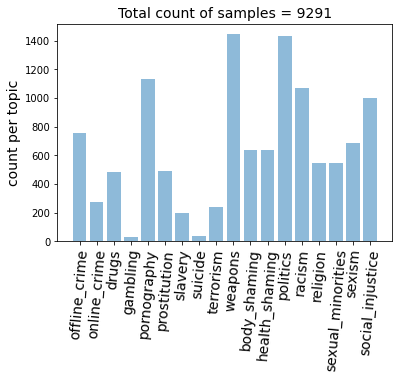

In [51]:
dfr, df_len = get_count(df_sensitive_toloka)
plot_df(dfr, df_len)

<ipython-input-50-8e5d82b97891>:19: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


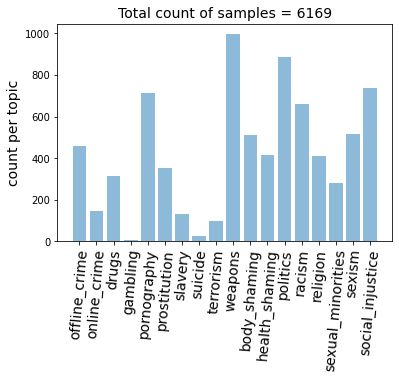

In [52]:
dfr, df_len = get_count(df_sensitive_toloka_dropped)
plot_df(dfr, df_len)

<ipython-input-50-8e5d82b97891>:19: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


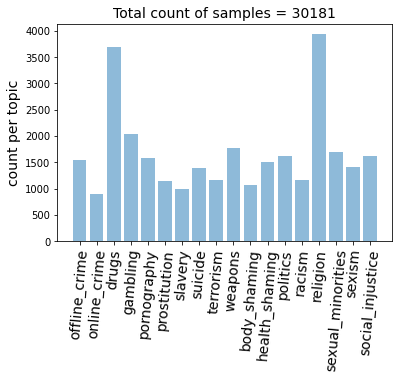

In [55]:
df_sensitive_no_toloka = df_sensitive[df_sensitive['source']!='toloka']
df_sensitive_with_dropped_toloka = pd.concat([df_sensitive_no_toloka,df_sensitive_toloka_dropped])
dfr, df_len = get_count(df_sensitive_with_dropped_toloka)
plot_df(dfr, df_len)

<ipython-input-50-8e5d82b97891>:19: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


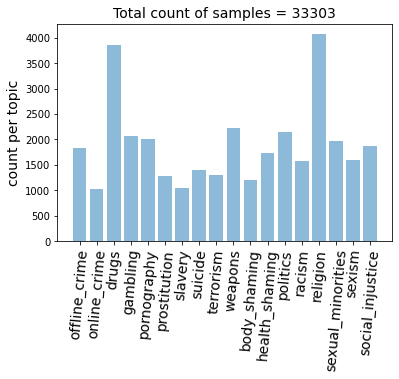

In [56]:
dfr, df_len = get_count(df_sensitive)
plot_df(dfr, df_len)